## Computer Vision CNN Classification Model from Scratch with PyTorch
### Praveen Tiwari

Implementation of the Computer Vision CNN Classification Model from Scratch with PyTorch

## 0. Import libraries

In [25]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Data

In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:05<00:00, 4587624.15it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267186.28it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5003071.04it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9091485.05it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

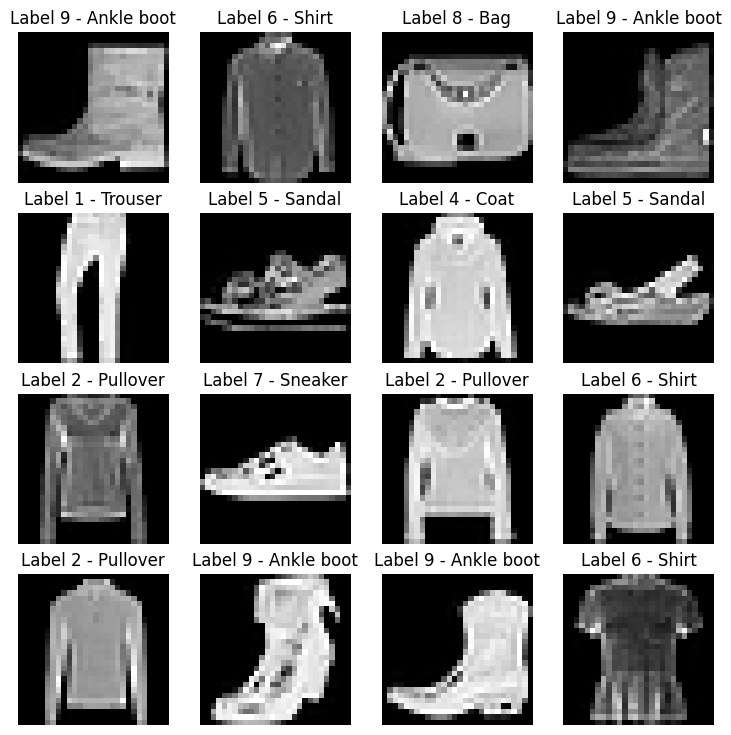

In [7]:
# Plot images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Label {label} - {class_names[label]}");
    plt.axis(False);

## 2. DataLoader

In [8]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32                                   # means create a bundle of 32 images in our train and test data

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False
                             )

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x783acbe77a90>, <torch.utils.data.dataloader.DataLoader object at 0x783acbe77a30>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 3. Build baseline model

In [10]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [11]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
    )

  def forward(self, x):
    return self.layer_stack(x)

model_0 = FashionMNISTModel(input_shape=28*28,
                            hidden_units=50,
                            output_shape=len(class_names)).to(device)

model_0

FashionMNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [20]:
# class FashionMNISTModel(nn.Module):
#   def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
#     super().__init__()
#     self.flat= nn.Flatten()
#     self.layer1 = nn.Linear(in_features=input_shape,
#               out_features=hidden_units)
#     self.layer2 = nn.Linear(in_features=hidden_units,
#               out_features=output_shape)


#   def forward(self, x):
#     x = self.flat(x)
#     x = self.layer1(x)
#     return self.layer2(x)

# model_0 = FashionMNISTModel(input_shape=28*28,
#                             hidden_units=50,
#                             output_shape=len(class_names)).to(device)

# model_0

FashionMNISTModel(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [23]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()                   #item() use for findout simple value from tensor
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Number of epochs
epochs = 5


for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0 # train loss per batch

  for batch, (image, label) in enumerate(train_dataloader):
    model_0.train()

    y_preds = model_0(image)
    loss = loss_fn(y_preds, label)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
            print(f"Looked at {batch * len(image)}/{len(train_dataloader.dataset)} samples")


  train_loss /= len(train_dataloader) # average the loss


  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for image, label in test_dataloader:

      test_preds = model_0(image)
      test_loss += loss_fn(test_preds, label)
      test_acc += accuracy_fn(y_true=label,
                              y_pred=test_preds.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.86036 | Test loss: 0.62355, Test acc: 78.68%

Epoch: 1
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.55346 | Test loss: 0.54029, Test acc: 81.21%

Epoch: 2
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.49798 | Test loss: 0.50905, Test acc: 82.22%

Epoch: 3
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47112 | Test loss: 0.48907, Test acc: 82.95%

Epoch: 4
------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked

## 4. Make predictions

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """
    Returns a dictionary containing the results of model predicting on data_loader.
    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for image, label in data_loader:
            y_pred = model(image)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, label)
            acc += accuracy_fn(y_true=label,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": round(acc, 2)}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.47870194911956787,
 'model_acc': 83.35}

---------------------------------------------------------------------------------------

## 5. Functionizing the code

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  train_loss, train_acc = 0, 0
  model.to(device)
  model.train()

  for batch, (img, label) in enumerate(data_loader):
    img, label = img.to(device), label.to(device)

    y_pred = model(img)
    loss = loss_fn(y_pred, label)
    train_loss += loss
    train_acc += accuracy_fn(y_true=label, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss, test_acc =  0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for img, label in data_loader:
      img, label = img.to(device), label.to(device)
      y_test = model(img)
      test_loss += loss_fn(y_test, label)
      test_acc += accuracy_fn(y_true=label, y_pred=y_test.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

## 6. Non-linear model

In [ ]:
#class model 1
class FashionMNISTModel1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
        )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModel1(input_shape=28*28,
                             hidden_units=8,
                             output_shape=len(class_names),
                             ).to(device)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.91913 | Train accuracy: 66.24%
Test loss: 0.73198 | Test accuracy: 72.89%

Epoch: 1
---------
Train loss: 0.61420 | Train accuracy: 77.61%
Test loss: 0.50056 | Test accuracy: 81.80%

Epoch: 2
---------
Train loss: 0.46734 | Train accuracy: 83.34%
Test loss: 0.50745 | Test accuracy: 82.43%

Epoch: 3
---------
Train loss: 0.45072 | Train accuracy: 83.89%
Test loss: 0.46860 | Test accuracy: 83.23%

Epoch: 4
---------
Train loss: 0.44036 | Train accuracy: 84.22%
Test loss: 0.47480 | Test accuracy: 83.10%



In [ ]:
torch.manual_seed(42)

model_0_results = eval_model(model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.47870194911956787,
 'model_acc': 83.35}

In [ ]:
torch.manual_seed(42)

model_1_results = eval_model(model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModel1',
 'model_loss': 0.4748002886772156,
 'model_acc': 83.1}

----------------------------------------------------------------------------------------

## 7. Building a Convolutional Neural Network (CNN)

In [ ]:
#CNN model

class FashionMNISTModelCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, # printing shapes in forward method helps
                  out_features=output_shape)
        )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x


In [ ]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")

Image shape: torch.Size([1, 28, 28])


In [ ]:
torch.manual_seed(42)

model_2 = FashionMNISTModelCNN(input_shape=1,
                               hidden_units=10,
                               output_shape=len(class_names)).to(device)

## 8. Training CNN

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train and test model
epochs = 5

for epoch in tqdm(range(epochs)):
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.03780 | Train accuracy: 62.35%
Test loss: 0.59721 | Test accuracy: 78.37%

Train loss: 0.54812 | Train accuracy: 80.10%
Test loss: 0.49704 | Test accuracy: 81.47%

Train loss: 0.45584 | Train accuracy: 83.61%
Test loss: 0.42410 | Test accuracy: 85.09%

Train loss: 0.41430 | Train accuracy: 85.14%
Test loss: 0.39136 | Test accuracy: 86.02%

Train loss: 0.38735 | Train accuracy: 86.22%
Test loss: 0.37821 | Test accuracy: 86.36%



In [ ]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelCNN',
 'model_loss': 0.40860652923583984,
 'model_acc': 85.3}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModel,0.478702,83.35
1,FashionMNISTModel1,0.474800,83.10
2,FashionMNISTModelCNN,0.408607,85.30


## 9. Plot random samples

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

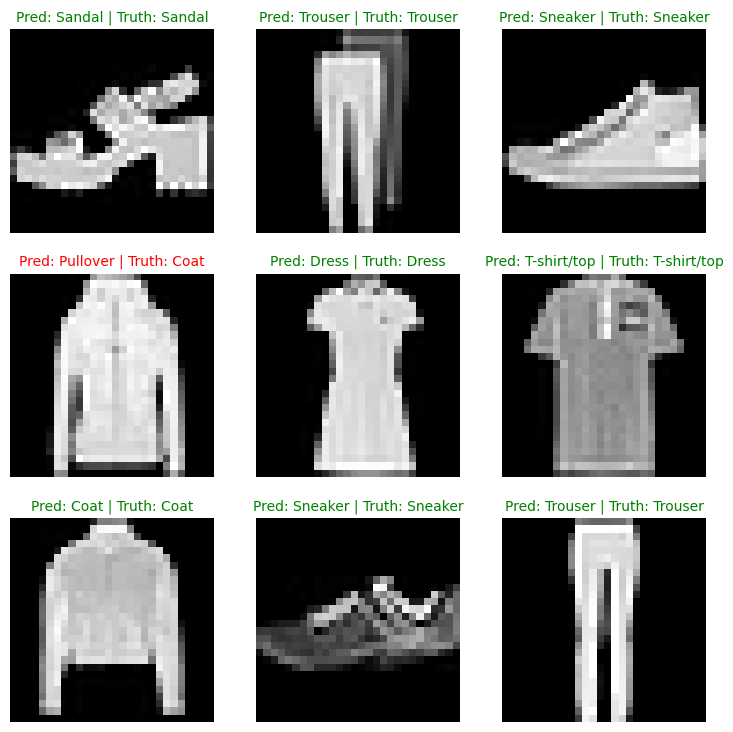

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [ ]:
!pip install torchmetrics

In [ ]:
# 1. Make predictions with trained model
y_preds = []
model_2.eval()

with torch.inference_mode():
  for img, label in tqdm(test_dataloader, desc="Making predictions"):
    img, label = img.to(device), label.to(device)
    y_logit = model_2(img)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

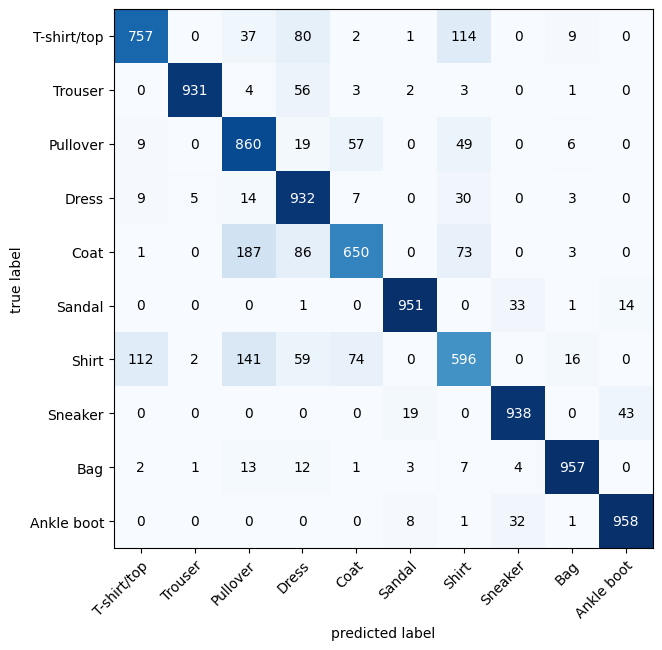

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

## Computer Vision CNN Classification Model from Scratch with PyTorch
### Mateusz Cedro

Implementation of the Computer Vision CNN Classification Model from Scratch with PyTorch